# Hierarchical Clustering of Questionair Responses

In [1]:
import numpy as np 
import pandas as pd
import xgboost
import shap
import matplotlib.pyplot as plt
from textwrap import wrap
from matplotlib import offsetbox
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

## Data preparation

In [2]:
df = pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

### Removing demographic information 

In [3]:
df1 = df.drop(columns=['Unnamed: 0', 'Timestamp',
       'Do you agree that your answers will be used for research purposes? ',
       'You identify yourself as:', 'Age', 'Nationality',
       'Have you been diagnosed with cancer? ']) 

removing open question and number of responces that are not rating 1-5

In [4]:
df1 = df1.drop(columns=['What motivates you the most to maintain healthy habits?',
       'When do you feel like you can/want to perform an activity that is beneficial to your health? ',
       'How do you remind yourself to perform activities aligned with your goals? ',
                       'How many daily reminders for health-related activities would you be willing to receive? ', 
                       'Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. '])

removing personality questions

In [5]:
personality_qestions = ['I see myself as someone who is reserved',
                        'I see myself as someone who is generally trusting',
       'I see myself as someone who tends to be lazy',
       'I see myself as someone who is relaxed, handles stress well',
       'I see myself as someone who has few artistic interests',
       'I see myself as someone who is outgoing, sociable',
       'I see myself as someone who tends to find fault with others',
       'I see myself as someone who does a thorough job',
       'I see myself as someone who gets nervous easily',
       'I see myself as someone who has an active imagination'
     ]

In [6]:
df1 = df1.drop(columns=personality_qestions)

In [7]:
df1 = df1.fillna(3) # neutral

### Colaps rating into positive (4,5),  neutral(3) and negative negative(1,2)

In [8]:
def squeezRating(rating):
    
    if rating <3:
        return 'negative'
    elif rating >3:
        return 'positive'
    else:
        return 'neutral'
        

In [9]:
dfs = df1.applymap(lambda x: squeezRating(x))

In [10]:
def rating2cat(rating):
    
    if rating == 'negative':
        return 0
    elif rating == 'positive':
        return 2
    else:
        return 1

In [11]:
dfs = dfs.applymap(lambda x: rating2cat(x))

In [12]:
dfs.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I am more likely to perform suggested health-related activity when I am not focused on any other tasks,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.
0,2,2,2,2,1,0,1,1,1,2,...,2,0,2,0,2,1,2,2,0,2
1,1,2,0,2,0,0,0,1,1,2,...,2,2,1,2,0,2,2,0,0,2
2,1,2,1,2,2,1,1,2,2,2,...,2,2,2,2,0,2,1,2,2,2
3,2,2,2,2,0,1,0,2,1,2,...,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,1,2,2,2,...,2,2,2,1,2,0,2,2,0,2


## Clustering based on the survey responces

In [13]:
def get_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dic = dendrogram(linkage_matrix, **kwargs)
    return dic

In [14]:
model3 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

model3 = model3.fit(dfs)

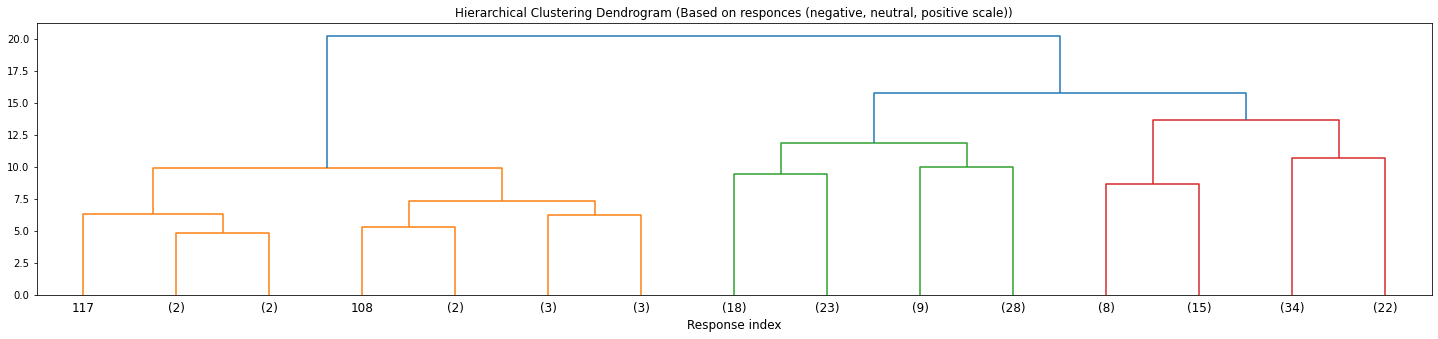

In [15]:
fig = plt.figure(figsize = (25,5))
plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
# plot the top three levels of the dendrogram
get_dendrogram(model3, truncate_mode='level', p=3)
plt.xlabel("Response index", fontsize= 12 )
plt.xticks(fontsize= 12 )
plt.show()

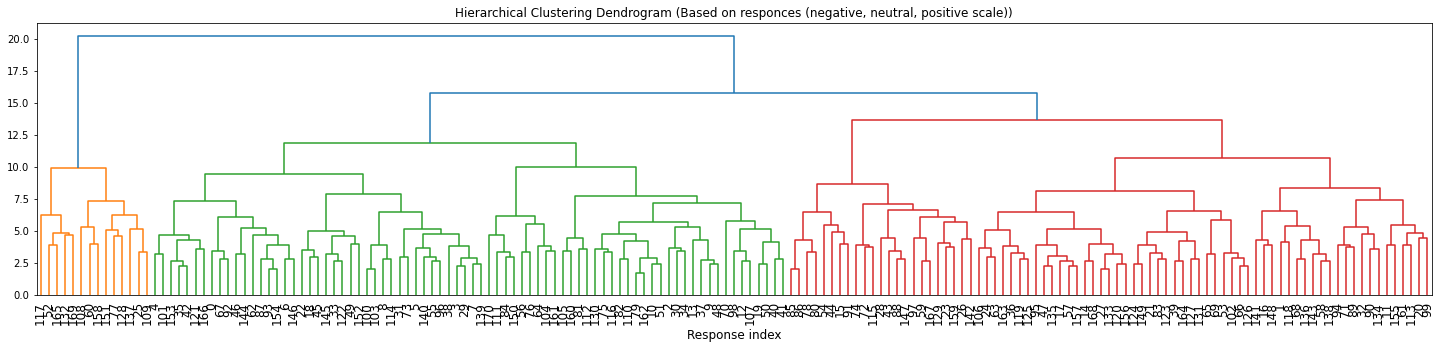

In [16]:
fig = plt.figure(figsize = (25,5))
plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
# plot the top three levels of the dendrogram
get_dendrogram(model3, truncate_mode='level', p=12)
plt.xlabel("Response index", fontsize= 12 )
plt.xticks(fontsize= 12 )
plt.show()

### Check Cluster stability

Random dropm of 10 responces

Dropped the following responces:  [160 169 111 146   9  12  83  93 136   3  80  97  41 154  47 135  65  14
  33  99]


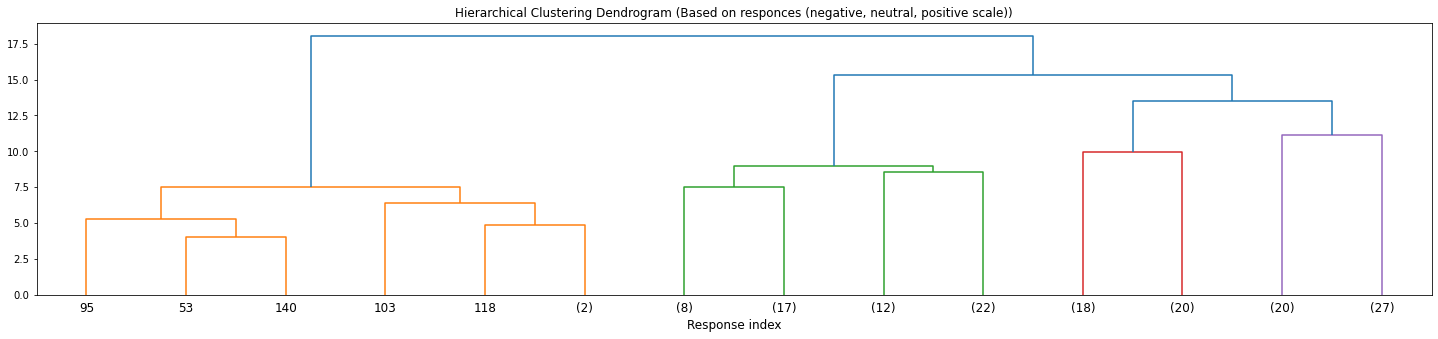

Dropped the following responces:  [ 86 157 121 128 116 147  81 110  26 145 164 119 160  18  55   2 106   3
 165  97]


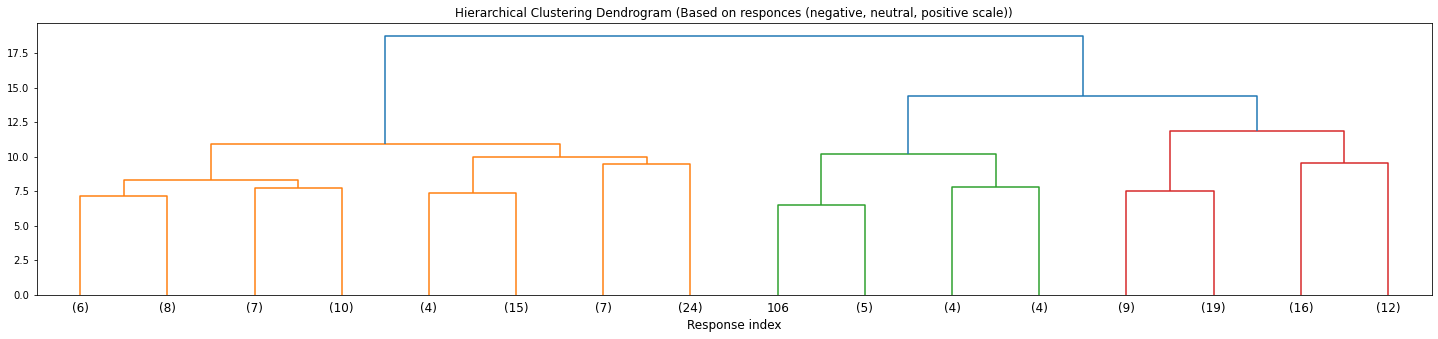

Dropped the following responces:  [ 50  12  56  33 141  65 154 118 169  50 148  89  79  26 115 142 147   4
  18  61]


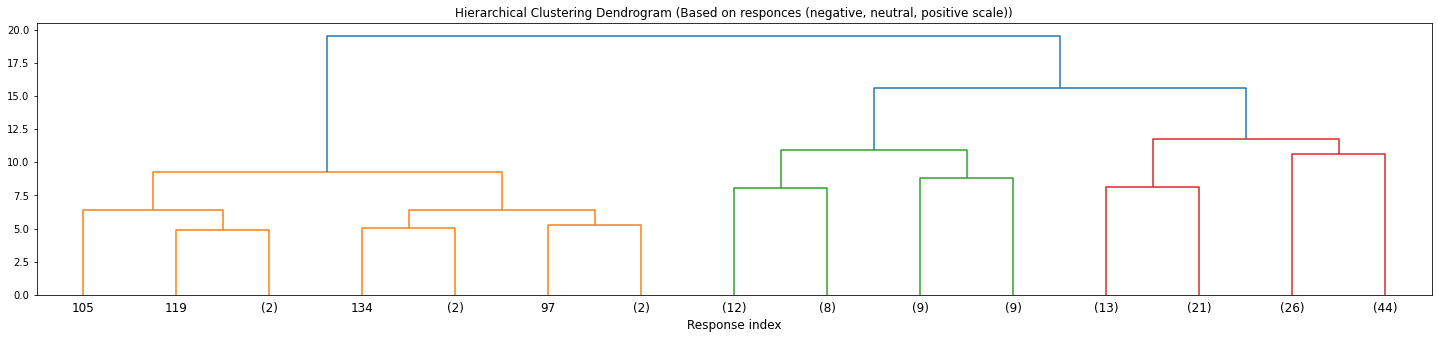

In [17]:
remove_n = 20
for i in range(3):
    drop_indices = np.random.choice(dfs.index, remove_n, replace=True)
    print("Dropped the following responces: ", drop_indices)
    df_subset = dfs.drop(drop_indices)
    model4 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
    model4 = model4.fit(df_subset)
    fig = plt.figure(figsize = (25,5))
    plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
    # plot the top three levels of the dendrogram
    get_dendrogram(model4, truncate_mode='level', p=3)
    plt.xlabel("Response index", fontsize= 12 )
    plt.xticks(fontsize= 12 )
    plt.show()

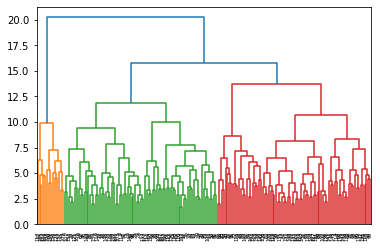

In [23]:
d = get_dendrogram(model3, truncate_mode='level', p=12)

In [24]:
# d['leaves'], d['leaves_color_list']

In [25]:
clust = pd.DataFrame(index =d['leaves'],data=d['leaves_color_list'], columns=['cluster'])

In [26]:
mCluster = pd.merge(dfs,clust, how='inner', left_index=True, right_index=True)

In [27]:
mCluster.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.,cluster
0,2,2,2,2,1,0,1,1,1,2,...,0,2,0,2,1,2,2,0,2,C2
1,1,2,0,2,0,0,0,1,1,2,...,2,1,2,0,2,2,0,0,2,C3
2,1,2,1,2,2,1,1,2,2,2,...,2,2,2,0,2,1,2,2,2,C2
3,2,2,2,2,0,1,0,2,1,2,...,2,2,2,2,2,2,2,2,2,C2
4,2,2,2,2,2,2,1,2,2,2,...,2,2,1,2,0,2,2,0,2,C2


### Responce histogram by cluster

I feel motivated to perform activities that I perceive having benefit to my health and well-being


To output multiple subplots, the figure containing the passed axes is being cleared


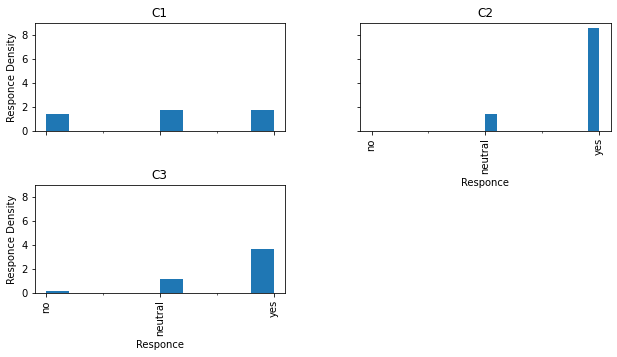

When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort) 


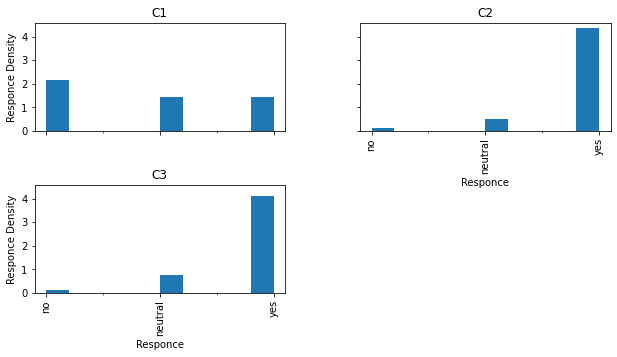

My family members motivate me to look after my health


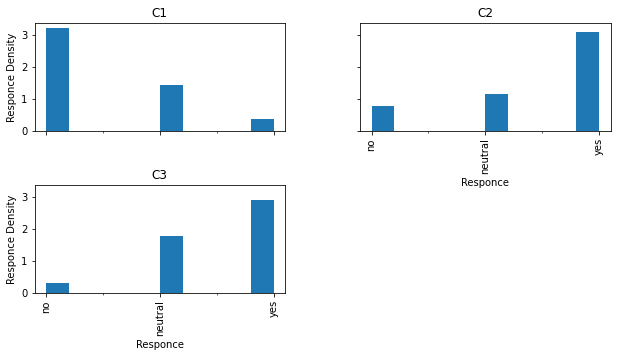

When I am in a good mood I am  motivated to perform activities that benefit my health


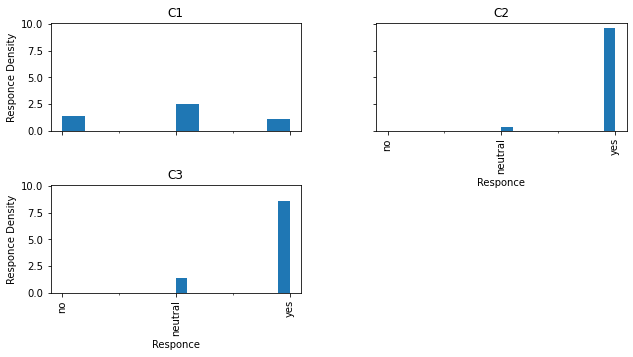

When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule


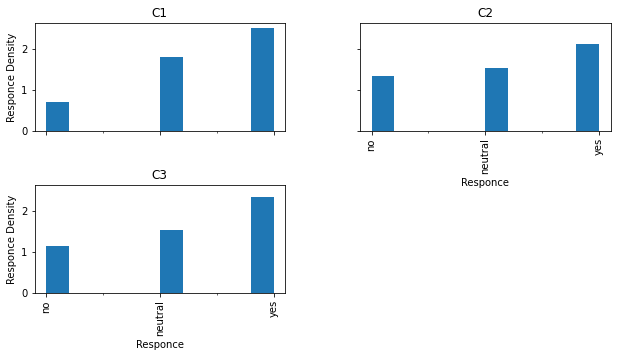

Before the visit to my doctor, I tend to be more compliant with my health recommendations


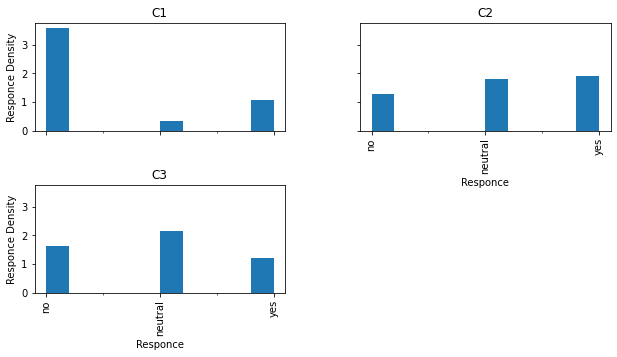

If I see that my peers perform health-related activities better than me,  I get discouraged 


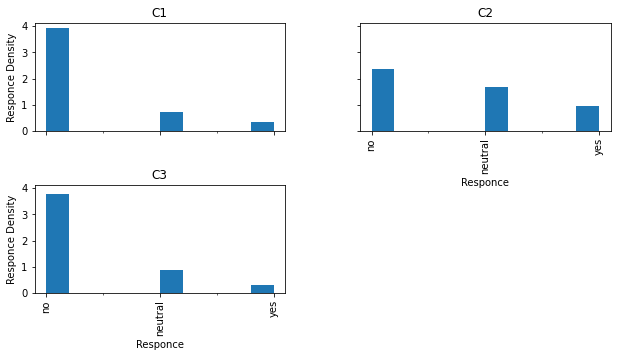

If I see that I perform health-related activities better than my peers I feel motivated


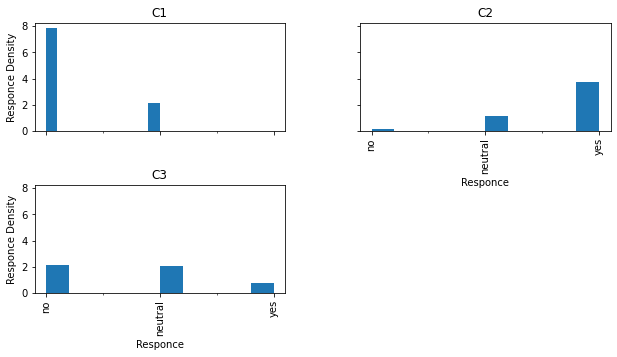

I am keen to perform a simple activity for a longer time when I compete with others


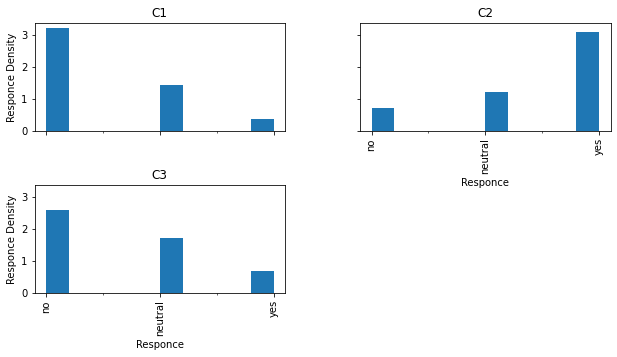

I am keen to perform a simple activity for a longer time when I want to break my own record


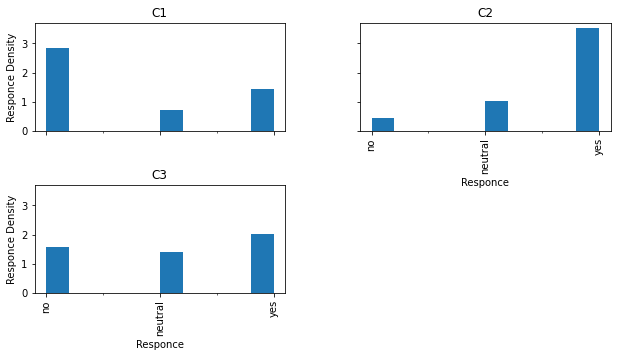

I feel stressed when I do not complete my daily health-related activities


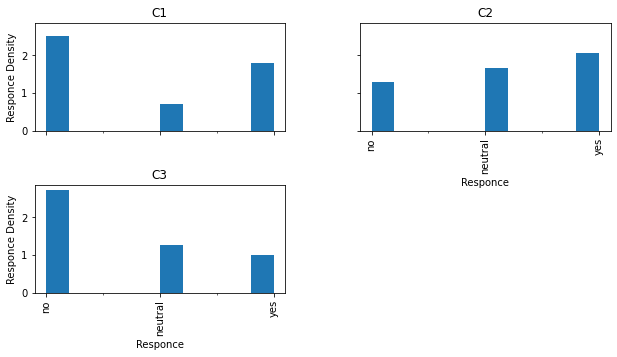

If I do not like recommended health-related activity, I would not perform it


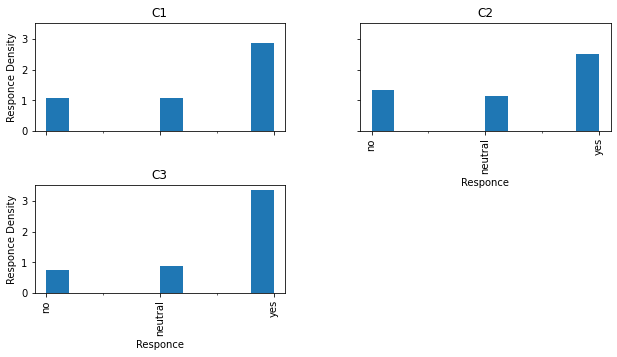

I am likely to perform a harder health-related activity when I am well rested


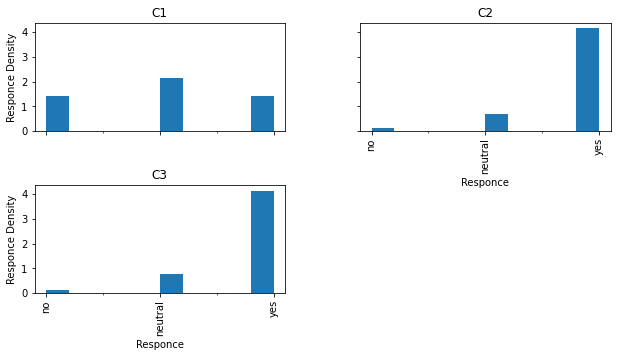

I am confident to perform a suggested health-related activity if I performed it already multiple times before


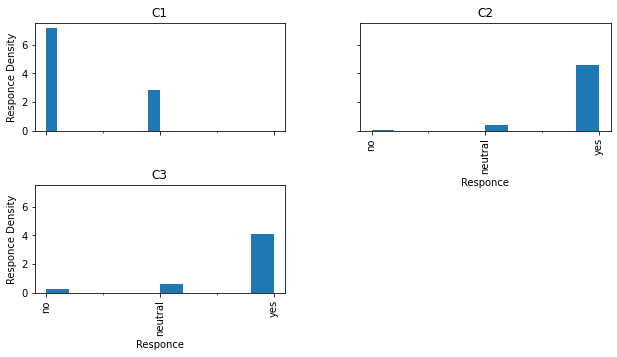

I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored


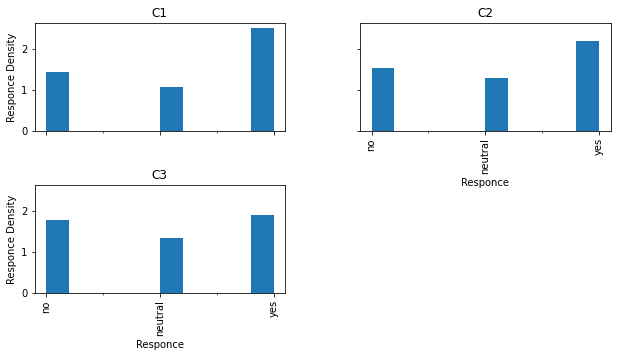

I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it 


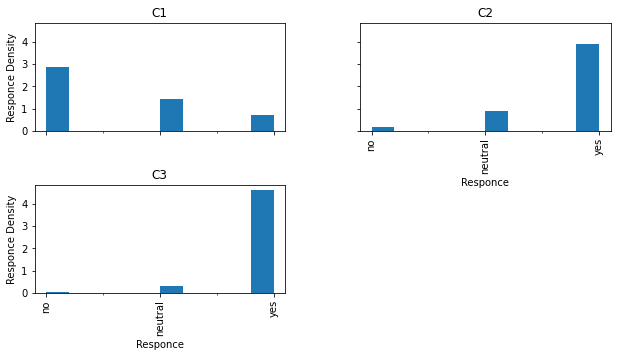

I am more likely to perform suggested health-related activity  when I am not focused on any other tasks


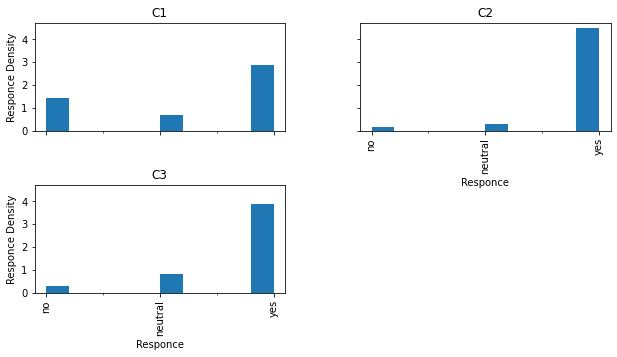

When I am stressed I am unlikely to respond to any reminders for health-related activities


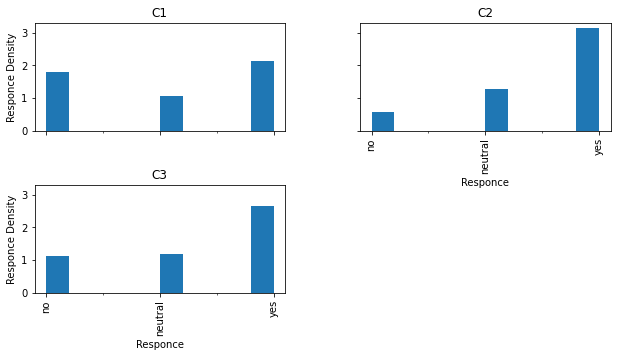

When I am stressed I find it helpful to perform a relaxing/calming down activity


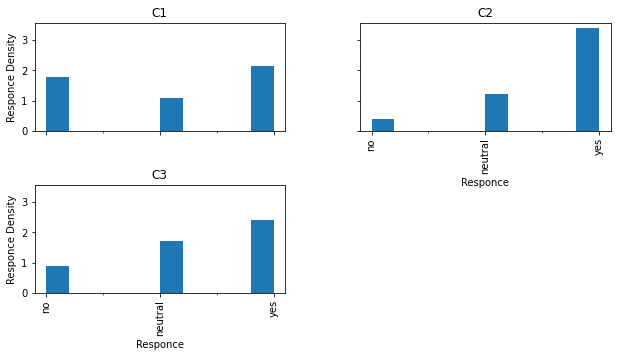

When I am tired  I am unlikely to respond to reminders for health-related activities


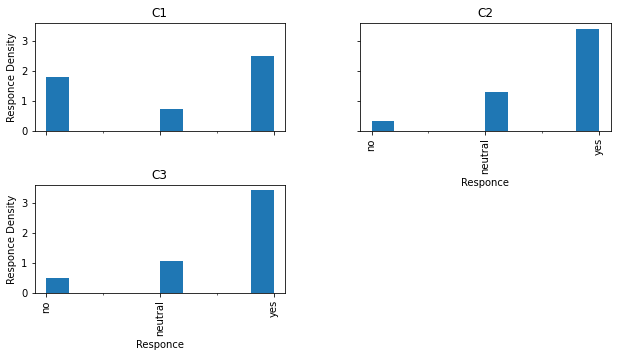

I am likely to respond to reminders for health-related activities when I am bored


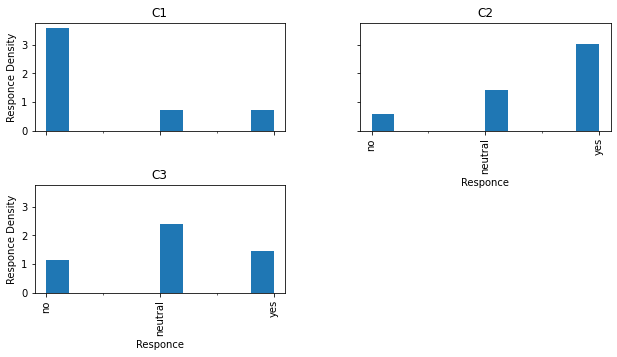

I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed


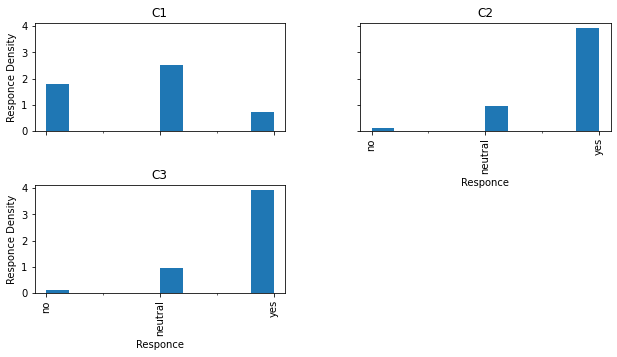

I am likely to respond to reminders for health-related activities when I am relaxed


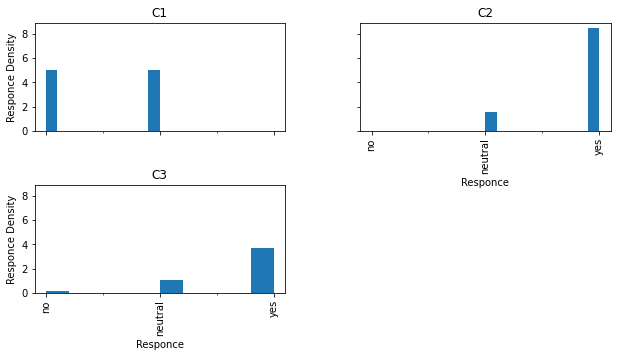

I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)


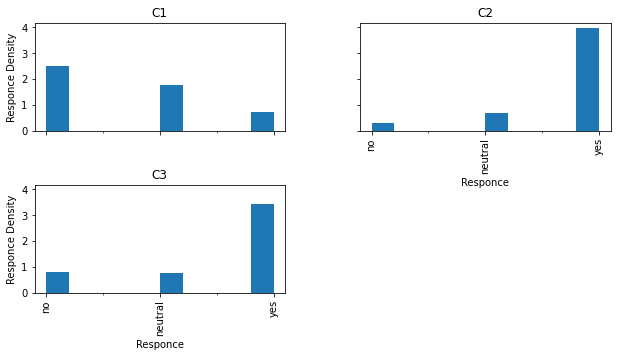

I would respond to reminders for health-related activities while I am walking. 


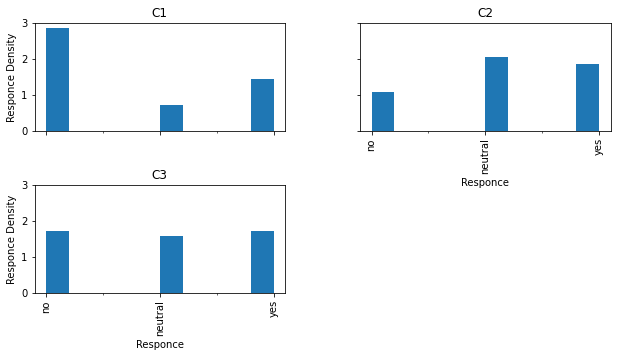

I would respond to reminders for health-related activities while I am sitting or standing. 


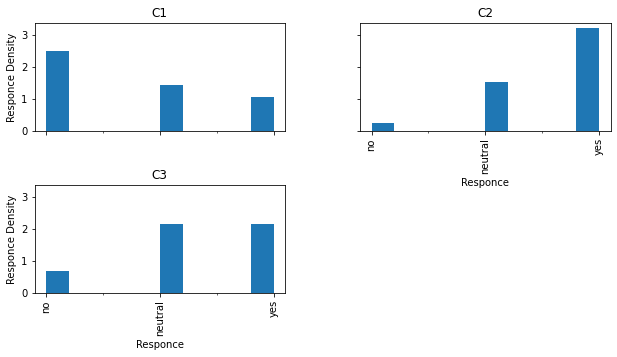

In [28]:
for q in dfs.columns:
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    ticks = [0,1,2]
    print(q)
    axarr = mCluster[q].hist(by=mCluster['cluster'], ax = ax, sharex=True, sharey=True, align='mid', density=True)
    for ax in axarr.flatten():
        ax.set_xlabel("Responce")
        ax.set_xticks(ticks, minor=False)
        ax.set_xticklabels(  ['no', 'neutral', 'yes'])
        ax.set_ylabel("Responce Density")
    
    plt.show()

### Questions that help us discriminate betweem clusters

In [29]:
forest = RandomForestClassifier(random_state=0)
forest.fit(dfs,clust.values.ravel())

RandomForestClassifier(random_state=0)

In [30]:
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

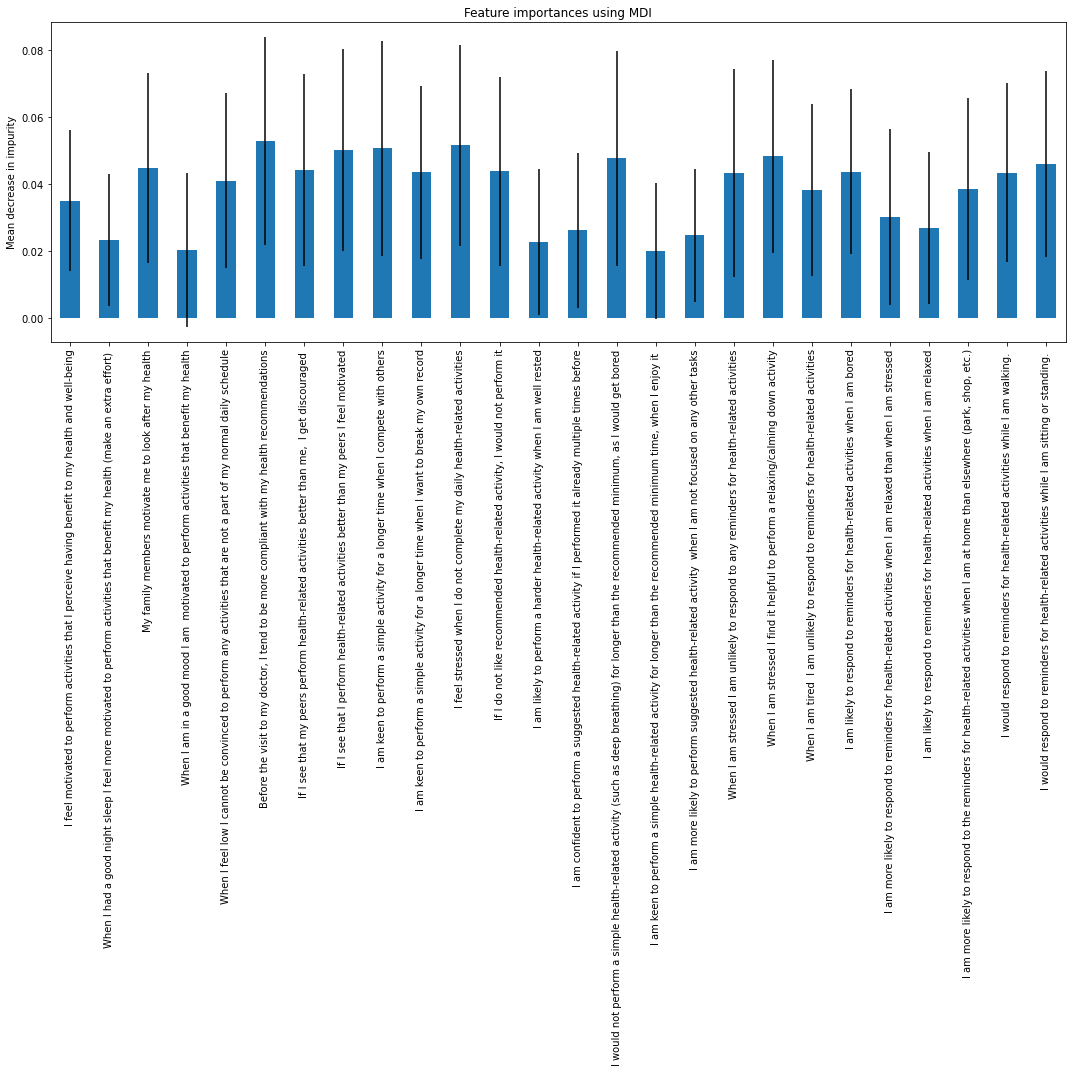

In [31]:
forest_importances = pd.Series(importances, index=dfs.columns)

fig, ax = plt.subplots(figsize = (15,15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [32]:
perm_importance = permutation_importance(forest, dfs,clust)

Text(0.5, 0, 'Permutation Importance')

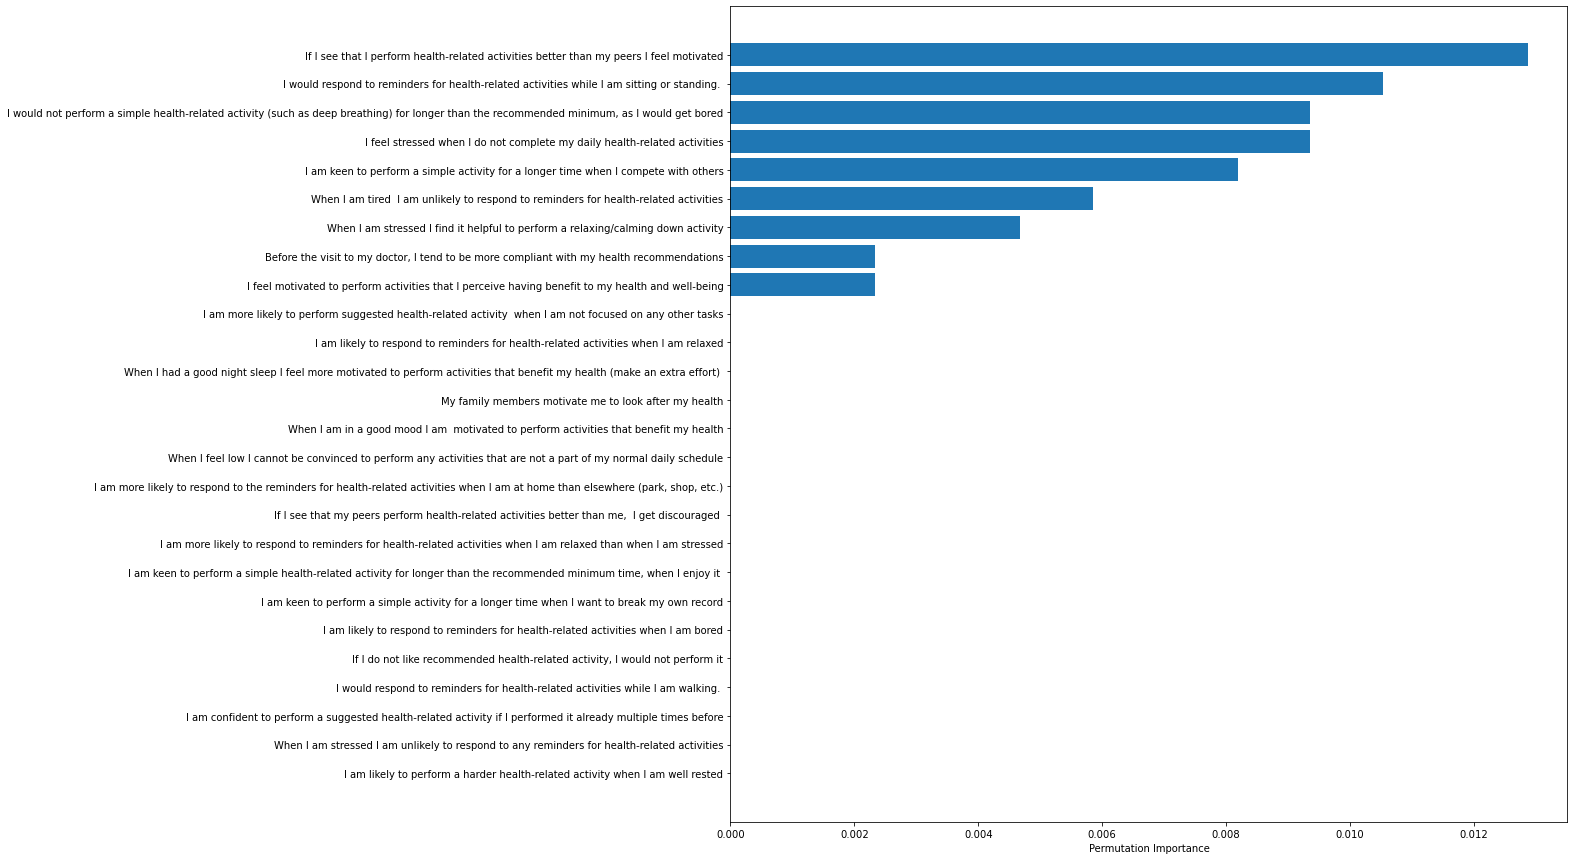

In [33]:
fig, ax = plt.subplots(figsize = (15,15))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(dfs.columns.values[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [51]:
top_questions = dfs.columns.values[sorted_idx][-9:]

### Dropping indisciminative questions and reclustering

In [52]:
dfnew = dfs[top_questions]

In [53]:
dfnew

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,"Before the visit to my doctor, I tend to be more compliant with my health recommendations",When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am keen to perform a simple activity for a longer time when I compete with others,I feel stressed when I do not complete my daily health-related activities,"I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored",I would respond to reminders for health-related activities while I am sitting or standing.,If I see that I perform health-related activities better than my peers I feel motivated
0,2,0,2,0,1,1,0,2,1
1,1,0,1,2,1,2,2,2,1
2,1,1,2,2,2,2,2,2,2
3,2,1,2,2,1,1,2,2,2
4,2,2,2,1,2,0,0,2,2
...,...,...,...,...,...,...,...,...,...
166,2,1,2,1,2,2,0,2,2
167,1,1,2,2,0,0,1,2,0
168,1,0,2,2,0,2,0,2,2
169,2,0,2,0,0,0,2,0,0


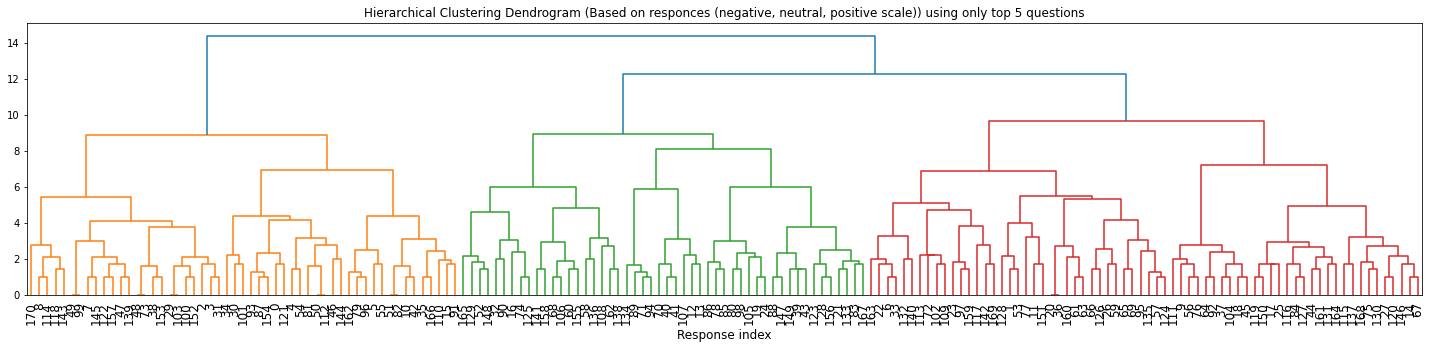

In [54]:
    model5 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
    model5 = model5.fit(dfnew)
    fig = plt.figure(figsize = (25,5))
    plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale)) using only top 5 questions')
    # plot the top three levels of the dendrogram
    get_dendrogram(model5, truncate_mode='level', p=12)
    plt.xlabel("Response index", fontsize= 12 )
    plt.xticks(fontsize= 12 )
    plt.show()

In [55]:
from sklearn.model_selection import KFold

In [56]:
list(dfnew.values)[0]

array([2, 0, 2, 0, 1, 1, 0, 2, 1], dtype=int64)

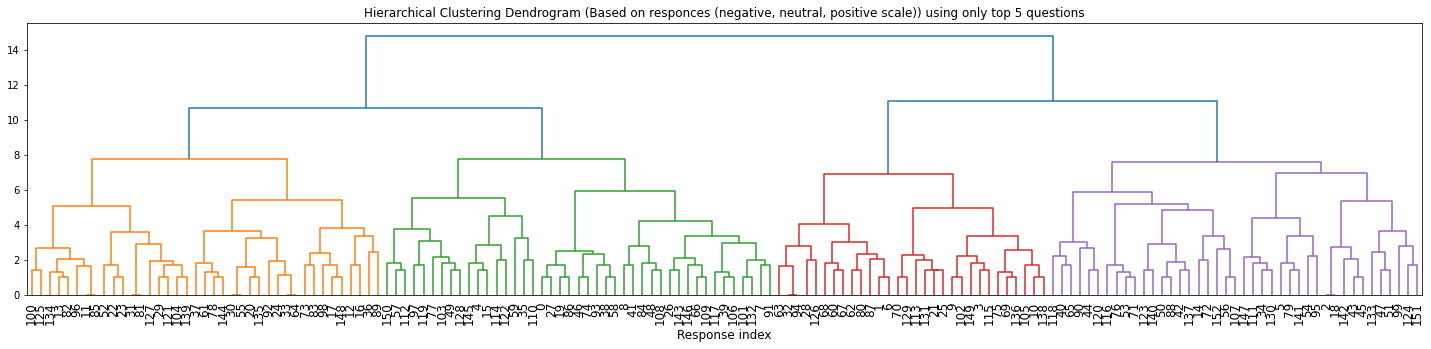

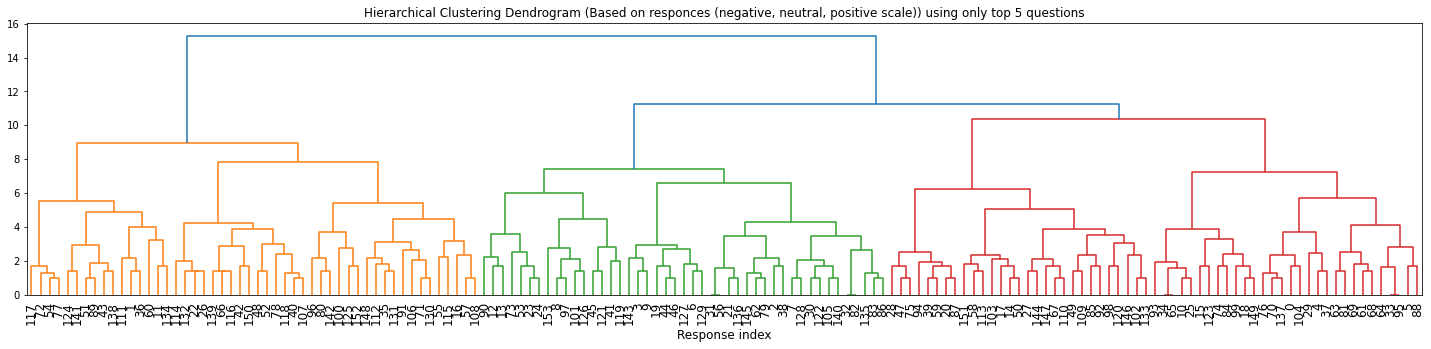

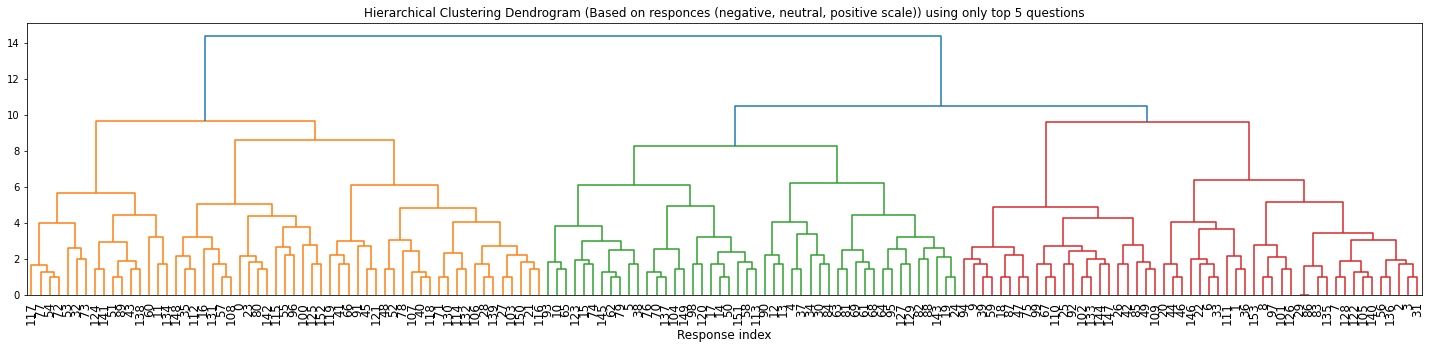

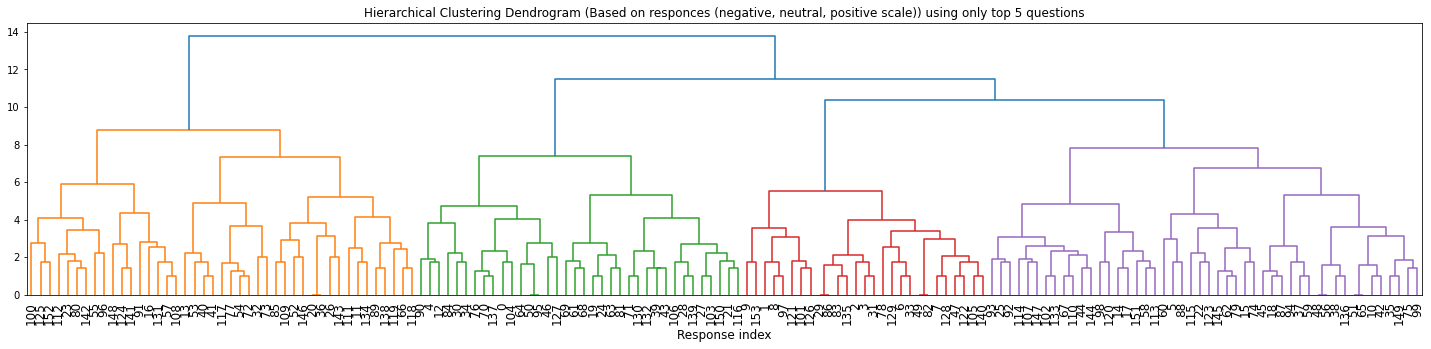

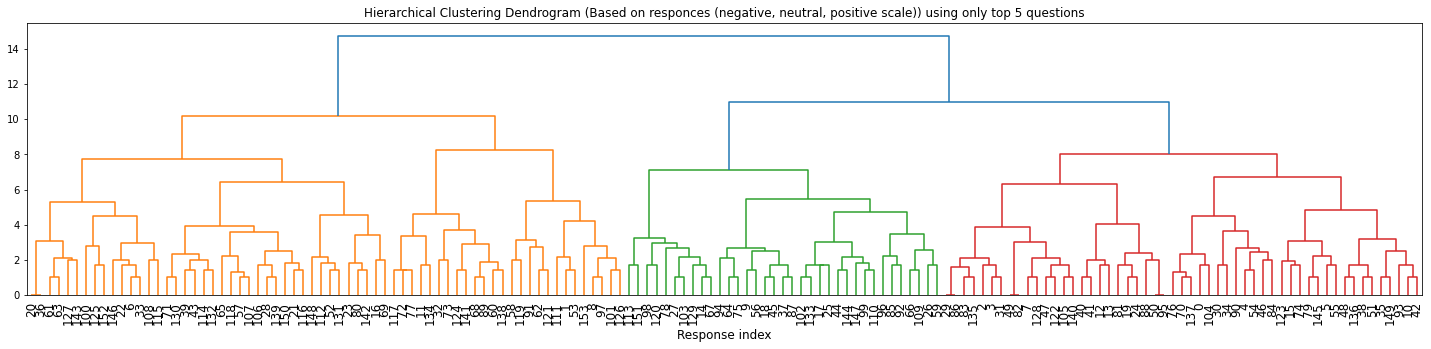

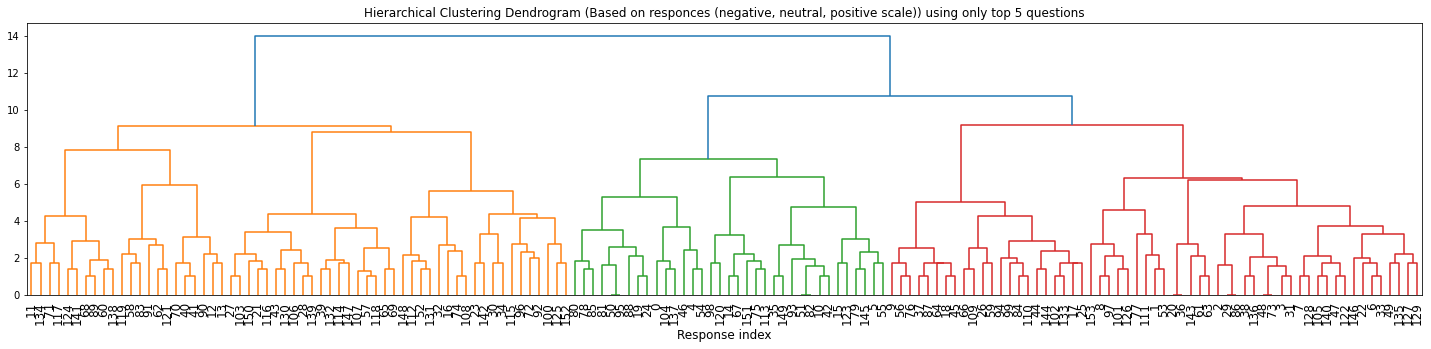

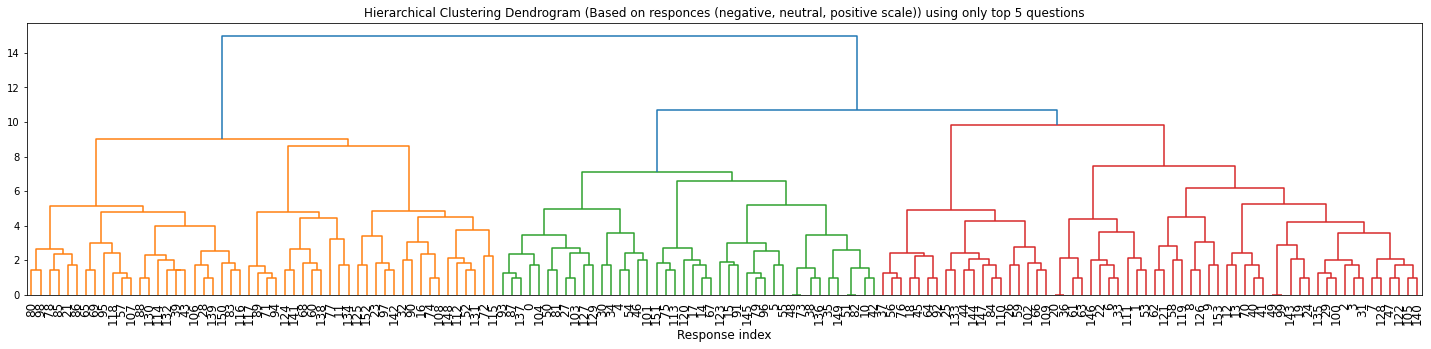

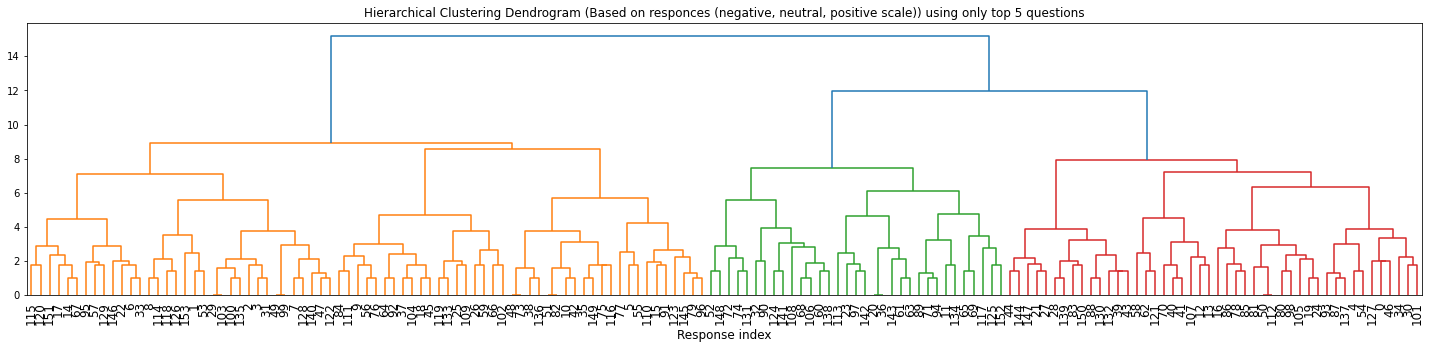

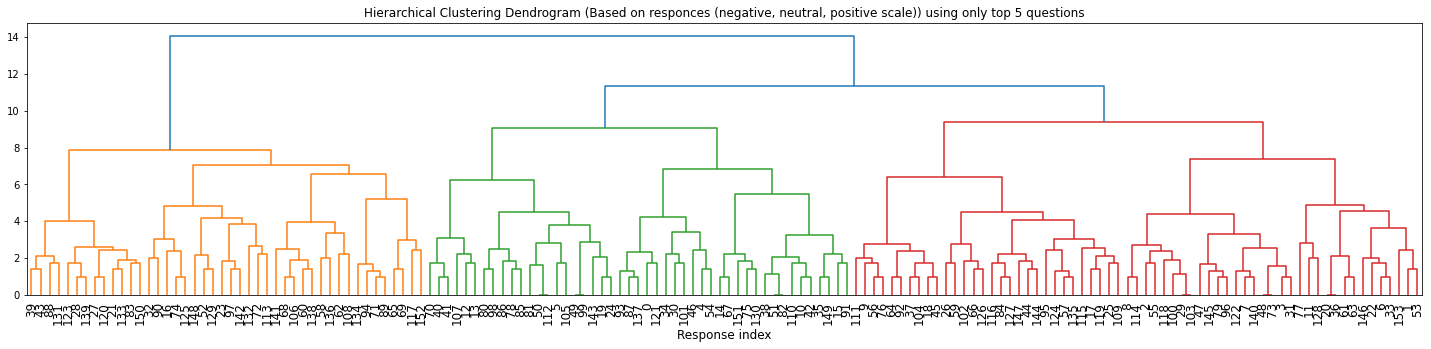

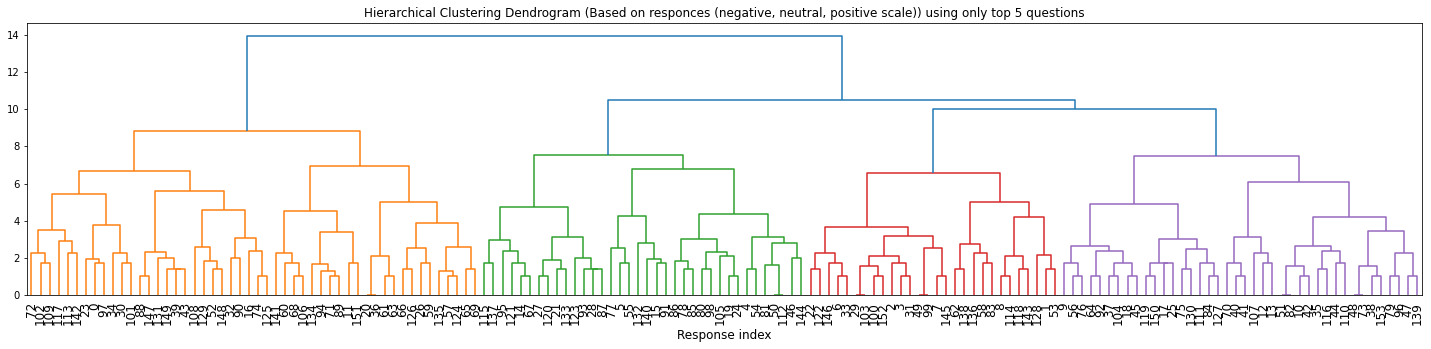

In [57]:
kf = KFold(n_splits=10)
for train, test in kf.split(dfnew):
    model5 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
    model5 = model5.fit(dfnew.values[train])
    fig = plt.figure(figsize = (25,5))
    plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale)) using only top 5 questions')
    # plot the top three levels of the dendrogram
    get_dendrogram(model5, truncate_mode='level', p=12)
    plt.xlabel("Response index", fontsize= 12 )
    plt.xticks(fontsize= 12 )
    plt.show()
    

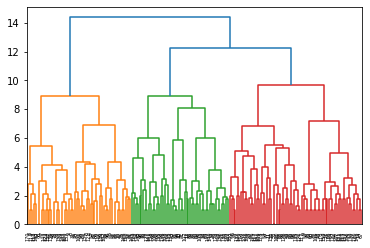

In [58]:
model5 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
model5 = model5.fit(dfnew)
d = get_dendrogram(model5, truncate_mode='level', p=12)

In [59]:
clust2 = pd.DataFrame(index =d['leaves'],data=d['leaves_color_list'], columns=['cluster'])

In [60]:
mCluster2 = pd.merge(dfnew,clust2, how='inner', left_index=True, right_index=True)

In [61]:
mCluster2.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,"Before the visit to my doctor, I tend to be more compliant with my health recommendations",When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am keen to perform a simple activity for a longer time when I compete with others,I feel stressed when I do not complete my daily health-related activities,"I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored",I would respond to reminders for health-related activities while I am sitting or standing.,If I see that I perform health-related activities better than my peers I feel motivated,cluster
0,2,0,2,0,1,1,0,2,1,C1
1,1,0,1,2,1,2,2,2,1,C3
2,1,1,2,2,2,2,2,2,2,C1
3,2,1,2,2,1,1,2,2,2,C1
4,2,2,2,1,2,0,0,2,2,C1


I feel motivated to perform activities that I perceive having benefit to my health and well-being


To output multiple subplots, the figure containing the passed axes is being cleared


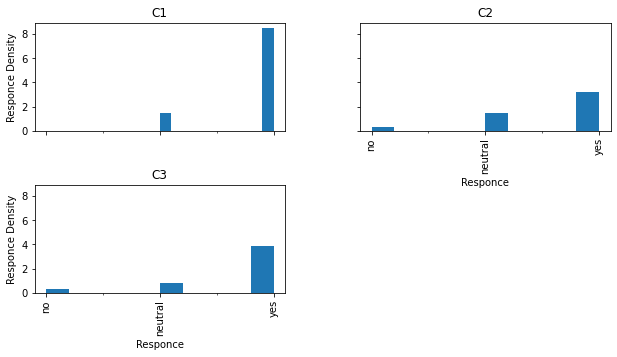

Before the visit to my doctor, I tend to be more compliant with my health recommendations


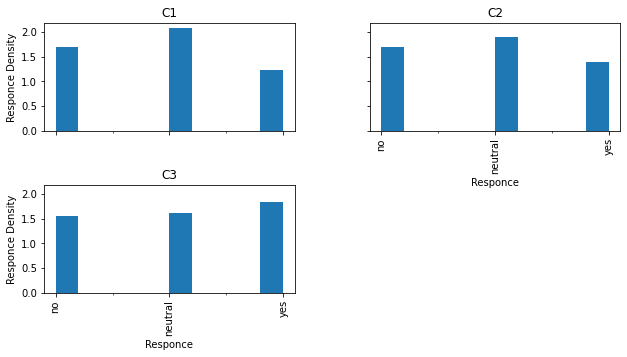

When I am stressed I find it helpful to perform a relaxing/calming down activity


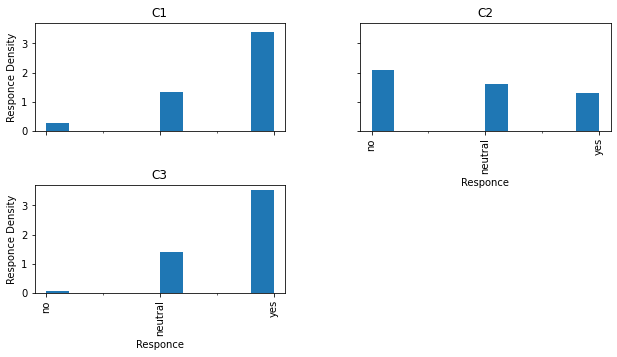

When I am tired  I am unlikely to respond to reminders for health-related activities


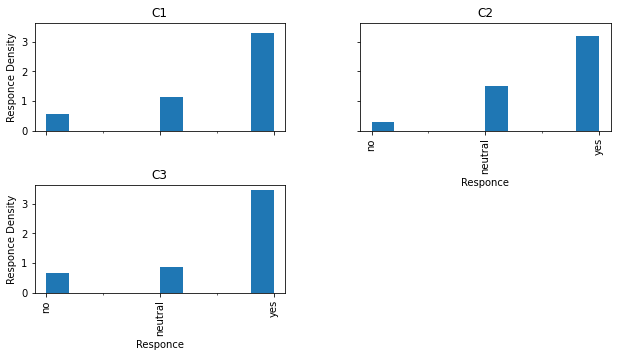

I am keen to perform a simple activity for a longer time when I compete with others


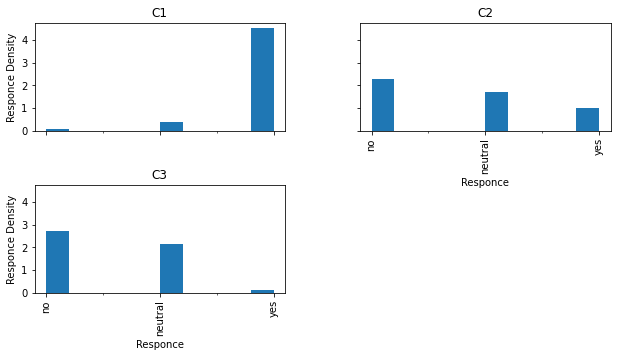

I feel stressed when I do not complete my daily health-related activities


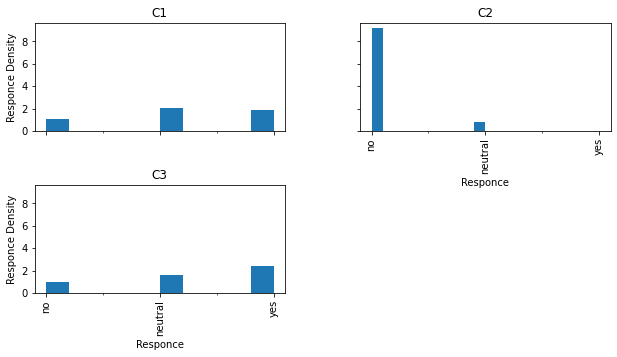

I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored


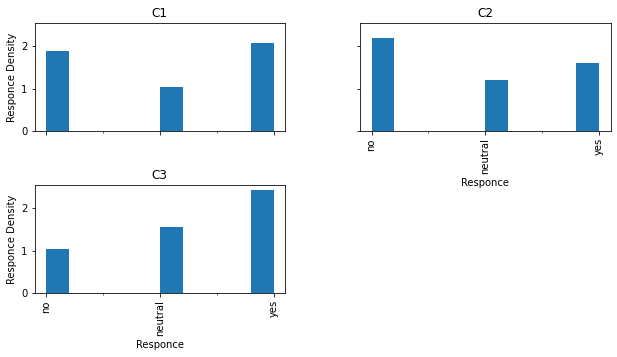

I would respond to reminders for health-related activities while I am sitting or standing. 


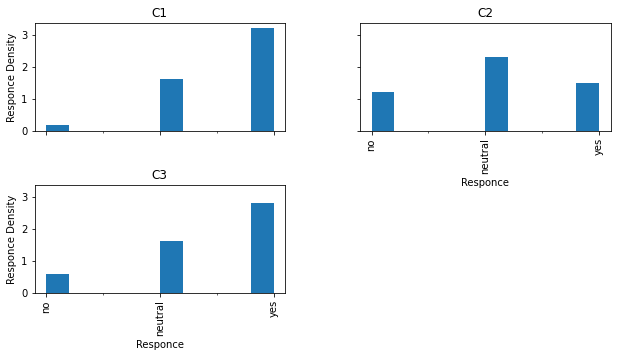

If I see that I perform health-related activities better than my peers I feel motivated


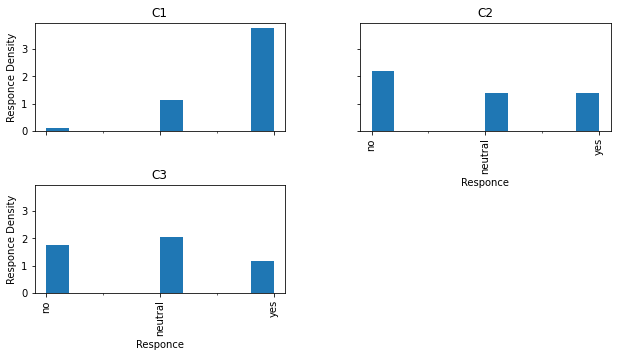

In [62]:
for q in dfnew.columns:
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    ticks = [0,1,2]
    print(q)
    axarr = mCluster2[q].hist(by=mCluster2['cluster'], ax = ax, sharex=True, sharey=True, align='mid', density=True)
    for ax in axarr.flatten():
        ax.set_xlabel("Responce")
        ax.set_xticks(ticks, minor=False)
        ax.set_xticklabels(  ['no', 'neutral', 'yes'])
        ax.set_ylabel("Responce Density")
    
    plt.show()

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train,X_test,Y_train,Y_test = train_test_split(dfnew, clust2, test_size=0.2, random_state=0)

In [65]:
rforest = RandomForestClassifier( max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, Y_train)
# print_accuracy(rforest.predict)
shap.initjs()
# explain all the predictions in the test set
explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Using 136 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/35 [00:00<?, ?it/s]

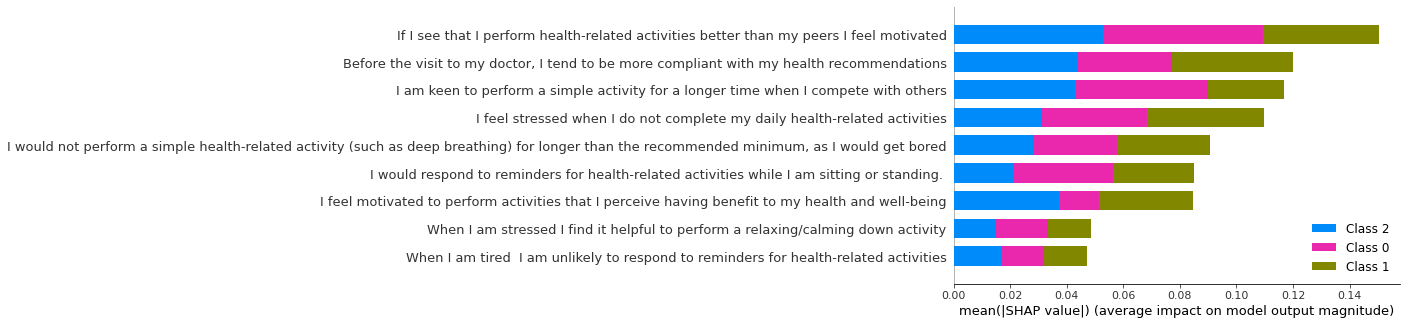

In [66]:
shap.summary_plot(shap_values, dfnew)

In [67]:
from sklearn.manifold import TSNE

In [68]:
y = clust2.values.ravel()

In [69]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(int(y[i][-1:]) / 4.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
        
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [74]:
X_embedded = TSNE(n_components=2, perplexity=60).fit_transform(dfnew)

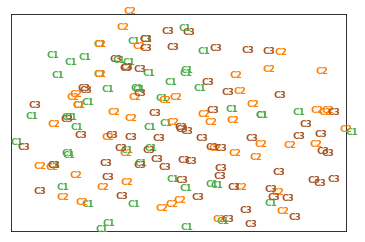

In [75]:
 plot_embedding(X_embedded, title=None)

## Personality 

In [76]:
personality = pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

In [77]:
keep = list(top_questions) +personality_qestions

In [78]:
personality = personality[keep]

In [79]:
personality

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,"Before the visit to my doctor, I tend to be more compliant with my health recommendations",When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am keen to perform a simple activity for a longer time when I compete with others,I feel stressed when I do not complete my daily health-related activities,"I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored",I would respond to reminders for health-related activities while I am sitting or standing.,If I see that I perform health-related activities better than my peers I feel motivated,I see myself as someone who is reserved,I see myself as someone who is generally trusting,I see myself as someone who tends to be lazy,"I see myself as someone who is relaxed, handles stress well",I see myself as someone who has few artistic interests,"I see myself as someone who is outgoing, sociable",I see myself as someone who tends to find fault with others,I see myself as someone who does a thorough job,I see myself as someone who gets nervous easily,I see myself as someone who has an active imagination
0,4,2,4.0,2.0,3.0,3,2.0,4.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,2,3.0,5.0,3.0,4,4.0,5.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,4.0,4.0,4.0,4,4.0,4.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,4.0,5.0,3.0,3,5.0,4.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4,5.0,3.0,5.0,2,1.0,4.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,5,3,5.0,3.0,4.0,4,1.0,5.0,5,3.0,5.0,3.0,4.0,1.0,5.0,2.0,5.0,2.0,4.0
167,3,3,5.0,4.0,2.0,2,3.0,5.0,2,4.0,3.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,3.0
168,3,1,5.0,4.0,1.0,5,2.0,5.0,4,5.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0
169,5,1,5.0,1.0,1.0,1,5.0,2.0,1,5.0,1.0,1.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0


In [80]:
personalityAndClust = pd.merge(personality,clust2, how='inner', left_index=True, right_index=True)

In [81]:
personalityAndClust =personalityAndClust.dropna()

In [82]:
personalityAndClust

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,"Before the visit to my doctor, I tend to be more compliant with my health recommendations",When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am keen to perform a simple activity for a longer time when I compete with others,I feel stressed when I do not complete my daily health-related activities,"I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored",I would respond to reminders for health-related activities while I am sitting or standing.,If I see that I perform health-related activities better than my peers I feel motivated,I see myself as someone who is reserved,I see myself as someone who is generally trusting,I see myself as someone who tends to be lazy,"I see myself as someone who is relaxed, handles stress well",I see myself as someone who has few artistic interests,"I see myself as someone who is outgoing, sociable",I see myself as someone who tends to find fault with others,I see myself as someone who does a thorough job,I see myself as someone who gets nervous easily,I see myself as someone who has an active imagination,cluster
67,4,1,4.0,4.0,3.0,4,2.0,4.0,3,3.0,4.0,4.0,2.0,2.0,3.0,1.0,3.0,3.0,5.0,C3
70,4,4,2.0,4.0,4.0,2,4.0,2.0,4,4.0,4.0,2.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,C2
71,3,4,3.0,5.0,2.0,2,4.0,3.0,3,4.0,2.0,4.0,3.0,2.0,2.0,4.0,3.0,4.0,5.0,C2
72,5,3,2.0,2.0,1.0,4,3.0,3.0,1,3.0,5.0,1.0,5.0,1.0,4.0,1.0,5.0,3.0,5.0,C3
73,4,4,4.0,4.0,4.0,3,4.0,4.0,4,2.0,4.0,4.0,3.0,2.0,3.0,3.0,4.0,3.0,4.0,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,5,3,5.0,3.0,4.0,4,1.0,5.0,5,3.0,5.0,3.0,4.0,1.0,5.0,2.0,5.0,2.0,4.0,C1
167,3,3,5.0,4.0,2.0,2,3.0,5.0,2,4.0,3.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,3.0,C2
168,3,1,5.0,4.0,1.0,5,2.0,5.0,4,5.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,C3
169,5,1,5.0,1.0,1.0,1,5.0,2.0,1,5.0,1.0,1.0,3.0,2.0,4.0,1.0,5.0,2.0,1.0,C3


### Personality trait computation

Scoring the BFI-10 scales:

Extraversion: 1R, 6; Agreeableness: 2, 7R; Conscientiousness: 3R, 8; Neuroticism: 4R, 9;

Openness: 5R; 10 (R = item is reversed-scored).


In [83]:
def reverse(num):
    return abs(num -6)

In [84]:
personalityAndClust.columns

Index(['I feel motivated to perform activities that I perceive having benefit to my health and well-being',
       'Before the visit to my doctor, I tend to be more compliant with my health recommendations',
       'When I am stressed I find it helpful to perform a relaxing/calming down activity',
       'When I am tired  I am unlikely to respond to reminders for health-related activities',
       'I am keen to perform a simple activity for a longer time when I compete with others',
       'I feel stressed when I do not complete my daily health-related activities',
       'I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored',
       'I would respond to reminders for health-related activities while I am sitting or standing. ',
       'If I see that I perform health-related activities better than my peers I feel motivated',
       'I see myself as someone who is reserved',
       'I see myself as some

In [85]:
def compute_personality_trait(score, rev_score):
    return score + reverse(rev_score)

In [86]:
personalityAndClust['Extraversion'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who is outgoing, sociable'],
                     row['I see myself as someone who is reserved']), axis = 1)
personalityAndClust['Agreeableness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who is generally trusting'],
                     row['I see myself as someone who tends to find fault with others']), axis = 1)
personalityAndClust['Conscientiousness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who does a thorough job'],
                     row['I see myself as someone who tends to be lazy']), axis = 1)
personalityAndClust['Neuroticism'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who gets nervous easily'],
                     row['I see myself as someone who is relaxed, handles stress well']), axis = 1)
personalityAndClust['Openness'] =personalityAndClust.apply(lambda row : compute_personality_trait(row['I see myself as someone who has an active imagination'],
                     row['I see myself as someone who has few artistic interests']), axis = 1)


### Personality and responce clusters

In [87]:
personalityAndClustOnly = personalityAndClust[['cluster', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']]

In [88]:
personalityAndClustOnly

,cluster,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
67,C3,6.0,9.0,5.0,7.0,9.0
70,C2,6.0,6.0,8.0,6.0,6.0
71,C2,4.0,4.0,5.0,7.0,9.0
72,C3,7.0,10.0,10.0,4.0,10.0
73,C1,7.0,7.0,6.0,6.0,8.0
...,...,...,...,...,...,...
166,C1,8.0,9.0,8.0,4.0,9.0
167,C2,7.0,6.0,8.0,8.0,6.0
168,C3,3.0,7.0,4.0,8.0,5.0
169,C3,5.0,6.0,10.0,5.0,5.0


In [89]:
personalityAndClustOnly.groupby("cluster").mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
cluster,,,,,
C1,6.074074,7.518519,7.111111,5.851852,7.333333
C2,5.575758,6.969697,6.666667,6.151515,6.969697
C3,5.810811,7.108108,7.189189,5.810811,6.729730


In [90]:
personalityAndClustOnly.groupby("cluster").agg(lambda x:x.value_counts().index[0]) # mode

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
cluster,,,,,
C1,7.0,7.0,6.0,5.0,7.0
C2,5.0,8.0,6.0,6.0,10.0
C3,7.0,7.0,7.0,4.0,6.0


### Personality and Motivation

In [91]:
keep2 = list(top_questions) + ['cluster', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

In [92]:
survey_and_personality = personalityAndClust[keep2]

In [93]:
survey_and_personality[list(top_questions)] = survey_and_personality[list(top_questions)].applymap(lambda x: squeezRating(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [94]:
top_questions

array(['I feel motivated to perform activities that I perceive having benefit to my health and well-being',
       'Before the visit to my doctor, I tend to be more compliant with my health recommendations',
       'When I am stressed I find it helpful to perform a relaxing/calming down activity',
       'When I am tired  I am unlikely to respond to reminders for health-related activities',
       'I am keen to perform a simple activity for a longer time when I compete with others',
       'I feel stressed when I do not complete my daily health-related activities',
       'I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored',
       'I would respond to reminders for health-related activities while I am sitting or standing. ',
       'If I see that I perform health-related activities better than my peers I feel motivated'],
      dtype=object)

In [95]:
survey_and_personality.groupby(top_questions[3]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
When I am tired I am unlikely to respond to reminders for health-related activities,,,,,
negative,6.636364,7.454545,8.090909,5.272727,6.090909
neutral,5.840000,6.960000,7.040000,5.800000,7.400000
positive,5.639344,7.213115,6.770492,6.114754,6.967213


In [96]:
survey_and_personality.groupby(top_questions[4]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
I am keen to perform a simple activity for a longer time when I compete with others,,,,,
negative,5.414634,6.731707,6.878049,6.097561,6.585366
neutral,6.000000,7.166667,6.875000,5.750000,7.041667
positive,6.156250,7.750000,7.218750,5.875000,7.437500


In [97]:
survey_and_personality.groupby(top_questions[5]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
I feel stressed when I do not complete my daily health-related activities,,,,,
negative,5.487179,6.769231,6.794872,6.000000,6.948718
neutral,6.148148,7.444444,7.370370,5.259259,6.814815
positive,5.903226,7.451613,6.903226,6.451613,7.161290


### Personality and Ability

In [98]:
survey_and_personality.groupby(top_questions[2]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
When I am stressed I find it helpful to perform a relaxing/calming down activity,,,,,
negative,5.882353,6.823529,7.411765,5.588235,7.176471
neutral,5.214286,7.000000,6.607143,6.214286,6.500000
positive,6.096154,7.384615,7.057692,5.903846,7.173077


In [99]:
survey_and_personality.groupby(top_questions[0]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
I feel motivated to perform activities that I perceive having benefit to my health and well-being,,,,,
negative,4.200000,5.200000,7.400000,5.600000,8.000000
neutral,5.947368,7.000000,6.526316,6.578947,6.789474
positive,5.876712,7.356164,7.082192,5.794521,6.958904


### Personality and Trigger

In [100]:
survey_and_personality.groupby(top_questions[1]).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
"Before the visit to my doctor, I tend to be more compliant with my health recommendations",,,,,
negative,5.727273,7.363636,7.151515,6.000000,7.000000
neutral,6.131579,7.315789,6.973684,5.815789,7.131579
positive,5.423077,6.730769,6.807692,6.038462,6.730769


In [101]:
df_preferred= pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

In [102]:
df_preferred = df_preferred[['Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. ',
                            'How many daily reminders for health-related activities would you be willing to receive? ']]

In [103]:
df_preferred_and_personality  = pd.merge(df_preferred,personalityAndClust[['cluster', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']], how='inner', left_index=True, right_index=True)

In [104]:
q = "How many daily reminders for health-related activities would you be willing to receive? "

In [105]:
df_preferred_and_personality[[q]] = df_preferred_and_personality[[q]].applymap(lambda x: x.replace("Non più di", "No more than"))

In [106]:
df_preferred_and_personality.groupby(q).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
How many daily reminders for health-related activities would you be willing to receive?,,,,,
0,5.769231,6.846154,7.153846,5.076923,7.076923
I would tolerate more than 4 reminders,4.250000,7.750000,7.000000,4.750000,6.750000
No more than 1,6.393939,7.030303,7.090909,6.151515,7.424242
No more than 2,5.645161,7.516129,6.677419,6.000000,6.870968
No more than 3,5.357143,7.071429,7.285714,6.214286,6.285714
No more than 4,5.000000,6.000000,7.000000,7.500000,6.000000


In [107]:
df_preferred_and_personality.groupby(q).agg(lambda x:x.value_counts().index[0]) # mode

,Select a simple activity that you would be happy to perform to improve your wellbeing. Consider this activity when answering later questions in this survey.,cluster,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
How many daily reminders for health-related activities would you be willing to receive?,,,,,,,
0,a walk in nature (30 minutes),C3,6.0,7.0,7.0,4.0,5.0
I would tolerate more than 4 reminders,a walk in nature (30 minutes),C1,4.0,7.0,7.0,5.0,7.0
No more than 1,a walk in nature (30 minutes),C2,7.0,8.0,6.0,7.0,8.0
No more than 2,a walk in nature (30 minutes),C3,5.0,8.0,6.0,4.0,6.0
No more than 3,a walk in nature (30 minutes),C3,4.0,7.0,8.0,6.0,7.0
No more than 4,a walk in nature (30 minutes),C1,6.0,3.0,5.0,7.0,4.0


### Personality and preffered activity

In [108]:
q2 = 'Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. '

In [109]:
def translate(choice):
    if choice == "una passeggiata nella natura (30 minuti)":
        return "a walk in nature (30 minutes)"
    elif choice == "garden bowl (innaffiare/prendersi cura di una pianta)":
        return "garden bowl (watering/caring for a plant)"
    else:
        return choice

In [110]:
df_preferred_and_personality[[q2]] = df_preferred_and_personality.apply(lambda row : translate(row[q2]), axis = 1)

In [111]:
df_preferred_and_personality.groupby(q2).mean()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
Select a simple activity that you would be happy to perform to improve your wellbeing. Consider this activity when answering later questions in this survey.,,,,,
a walk in nature (30 minutes),5.826087,7.231884,7.014493,5.869565,7.072464
deep breathing exercise (5 minutes),6.285714,7.142857,7.642857,6.214286,6.214286
garden bowl (watering/caring for a plant),5.400000,6.600000,6.200000,5.800000,7.200000
gratitude journal (write down 3 things you are grateful for today),6.500000,8.500000,6.500000,4.500000,7.000000
imagery training (visualize yourself healthy and happy),6.000000,8.000000,6.500000,6.000000,8.500000
tai chi (5 minutes),4.250000,6.500000,6.250000,7.250000,7.500000


In [112]:
df_preferred_and_personality.groupby(q2).agg(lambda x:x.value_counts().index[0]) # mode

,How many daily reminders for health-related activities would you be willing to receive?,cluster,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
Select a simple activity that you would be happy to perform to improve your wellbeing. Consider this activity when answering later questions in this survey.,,,,,,,
a walk in nature (30 minutes),No more than 1,C2,5.0,7.0,6.0,4.0,6.0
deep breathing exercise (5 minutes),No more than 1,C3,7.0,8.0,8.0,4.0,7.0
garden bowl (watering/caring for a plant),No more than 2,C1,4.0,6.0,5.0,5.0,7.0
gratitude journal (write down 3 things you are grateful for today),No more than 2,C3,7.0,8.0,7.0,5.0,8.0
imagery training (visualize yourself healthy and happy),No more than 2,C1,6.0,7.0,5.0,7.0,8.0
tai chi (5 minutes),No more than 2,C1,4.0,8.0,6.0,5.0,7.0


## Survey responce Clusters and personality

In [139]:
X_train,X_test,Y_train,Y_test = train_test_split(df_preferred_and_personality[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']], df_preferred_and_personality[['cluster']], test_size=0.3, random_state=0)

In [140]:
rforest2 = RandomForestClassifier( max_depth=None, min_samples_split=15, random_state=0)
rforest2.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(min_samples_split=15, random_state=0)

In [141]:
np.unique(Y_test)

array(['C1', 'C2', 'C3'], dtype=object)

In [142]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, rforest2.predict(X_test), target_names=np.unique(Y_test)))

              precision    recall  f1-score   support

          C1       0.43      0.38      0.40         8
          C2       0.45      0.50      0.48        10
          C3       0.33      0.33      0.33        12

    accuracy                           0.40        30
   macro avg       0.41      0.40      0.40        30
weighted avg       0.40      0.40      0.40        30



In [143]:
X_train,X_test,Y_train,Y_test = train_test_split(df_preferred_and_personality[['Conscientiousness']], df_preferred_and_personality[['cluster']], test_size=0.3, random_state=0)

In [146]:
rforest3 = RandomForestClassifier( max_depth=None, min_samples_split=10, random_state=0)
rforest3.fit(X_train, Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(min_samples_split=10, random_state=0)

In [147]:
print(classification_report(Y_test, rforest3.predict(X_test), target_names=np.unique(Y_test)))

              precision    recall  f1-score   support

          C1       0.50      0.25      0.33         8
          C2       0.43      0.60      0.50        10
          C3       0.42      0.42      0.42        12

    accuracy                           0.43        30
   macro avg       0.45      0.42      0.42        30
weighted avg       0.44      0.43      0.42        30

